# Pre-Process

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
sys.path.append('D:\\Compute Science\\Machine Learning\\论文\\项目\\FairSPL\\venv_torch')
sys.path.append('D:\\Compute Science\\Machine Learning\\论文\\项目\\FairSPL\\venv_torch\\lib\\site-packages')

In [2]:
import json
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy.special
import scipy
from livelossplot import PlotLosses
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


from dataset import fetch_data
from models.PrejudiceRemover import classifier_model, pr_loss
from eval import Evaluator
from utils import get_curriculum_stages
# from tmp.AdversarialDebiasing_copied2_before_lr import AdversarialDebiasing

In [3]:
data = fetch_data("compas")
print("data.x_train.shape: ", data.x_train.shape)
print("data.x_test.shape: ", data.x_test.shape)
origin_evaluator, train_evaluator, test_evaluator = Evaluator(data.s_train, "origin"), Evaluator(data.s_train,
                                                                                                 "train"), Evaluator(
    data.s_test, "test")
if data.s_val is not None:
    val_evaluator = Evaluator(data.s_val, "val")

n_features, n_classes, n_groups = data.x_train.shape[1], len(np.unique(data.y_train)), len(np.unique(data.s_train))
if n_classes == 2:
    n_classes = 1
if n_groups == 2:
    n_groups = 1

print("========== before train ==========")
origin_res = origin_evaluator(data.y_train, no_train=True)

Dataset statistic - #total: 26365; #train: 14128; #val.: 3532; #test: 8705; #dim.: 401

data.x_train.shape:  (14128, 401)
data.x_test.shape:  (8705, 401)
========== before train ==========
========== Results on origin ==========
Grp. 0 - #instance: 8452; #pos : 4060
Grp. 1 - #instance: 5676; #pos : 3443
Demographic parity: 0.126229; Equal opportunity: 0.000000


# Baseline

In [4]:
from sklearn.linear_model import LogisticRegression
clf_no_debias = LogisticRegression(random_state=0).fit(data.x_train, data.y_train)
clf_no_debias.score(data.x_test, data.y_test)

KeyboardInterrupt: 

In [ ]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_no_debias.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_no_debias.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

# Fairness-Aware classifier with Prejudice Remover Regularizer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = classifier_model(feature=n_features, Hneuron1=data.x_train.shape[1], output=n_classes, dropout=0.2).to(device)
classes_ = np.unique(data.y_train)

In [5]:
def train_info(s_train, s_val=None):
    train_evaluator = Evaluator(s_train, "train")
    if s_val is not None:
        val_evaluator = Evaluator(s_val, "val")
        return train_evaluator, val_evaluator
    return train_evaluator, None

def decision_function(clf, X):

    if scipy.sparse.issparse(X):
        X = X.todense()
    X = torch.tensor(X.astype(np.float32)).to(device)
    pred_labels_list = []
    dataBatch = DataLoader(X, batch_size=512, shuffle=False,
                           drop_last=False)
    for X_b in dataBatch:
        clf.eval()
        pred_labels, pred_logits = clf.forward(X_b)
        pred_labels_list += pred_labels.cpu().detach().numpy().tolist()

    scores = np.array(pred_labels_list, dtype=np.float64).reshape(-1, 1)
    return scores.ravel() if scores.shape[1] == 1 else scores

def predict(clf, X):
    scores = decision_function(clf, X)
    if scores.ndim == 1:
        if X.shape[0] == 1:
            indices = (scores > 0.5).astype(np.int).reshape((-1,))
        else:
            indices = (scores > 0.5).astype(np.int).reshape((-1,))
    else:
        indices = scores.argmax(axis=1)
    
    
    return classes_[indices]
    
    
def init_parameters(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            # nn.init.xavier_uniform(m.weight.data)
            torch.nn.init.normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
    
# eta_value = [0.0,0.5,1.0,2.0,5.0,10.0,20.0] # Parameter for Prejudice Remover
def train(clf, X, y, s, num_epochs=500, batch_size=512, starter_learning_rate=0.0008, eta=1, validation_set=None):

    init_parameters(clf)
    classes_ = np.unique(y)
    X_val, y_val, s_val = validation_set

    train_evaluator, val_evaluator = train_info(s, s_val)

    if scipy.sparse.issparse(X_val):
        X_val = X_val.todense()
    X_val = torch.tensor(X_val.astype(np.float32)).to(device)
    y_val = torch.tensor(y_val.astype(np.float32)).to(device)
    s_val = torch.tensor(s_val.astype(np.float32)).to(device)
    y_val = y_val.unsqueeze(1)
    s_val = s_val.unsqueeze(1)
    val_loss_list = []

    # else:
    # train_evaluator, _ = self.train_info(s)

    if scipy.sparse.issparse(X):
        X = X.todense()
    X = torch.tensor(X.astype(np.float32)).to(device)
    y = torch.tensor(y.astype(np.float32)).to(device)
    s = torch.tensor(s.astype(np.float32)).to(device)
    y = y.unsqueeze(1)
    s = s.unsqueeze(1)

    train_loss_list = []
    train_eval_list = []
    val_eval_list = []
    batch_id = 0
    stopped_batch_ids = []
    dataBatch = DataLoader(TensorDataset(X, y, s), batch_size=batch_size, shuffle=True,
                           drop_last=False)

    logs = {}
    groups = {'accuracy': ['train_acc', 'val_acc'],
              'loss': ['train_loss', 'val_loss']}
    # if self.debias:
    groups['dp'] = ['train_dp', 'val_dp']
    groups['eop'] = ['train_eop', 'val_eop']
    # groups['aod'] = ['train_aod', 'val_aod']
    liveloss = PlotLosses(groups=groups)
        
    # optimizer
    classifier_opt = torch.optim.Adam(clf.parameters(), lr=starter_learning_rate, weight_decay=1e-5)
    clf_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=classifier_opt, T_max=num_epochs)
    
    loss_clf = F.binary_cross_entropy_with_logits

    with tqdm(range(num_epochs), colour='green') as epochs:
        epochs.set_description("Classifier Training Epoch")
        for epoch in epochs:
            for X_b, y_b, s_b in dataBatch:
                clf.train()
                classifier_opt.zero_grad()
                pred_labels, pred_logits = clf.forward(X_b)
                output_a, output_b = pred_labels[s_b == 0], pred_labels[s_b == 1]
#                 print("output_a, output_b: ", torch.isnan(output_a).any(), torch.isnan(output_b).any())
                loss = loss_clf(pred_logits, y_b, reduction='mean')
                #############################################
#                 PILoss = pr_loss(output_a, output_b,eta)
                loss += 0
                loss.backward()
                classifier_opt.step()

                acc_b = (pred_labels.round() == y_b).float().sum().item() / X_b.size(0)
                epochs.set_postfix(loss=loss.item(), acc=acc_b)

                batch_id += 1
                if batch_id % 50 == 0:
                    with torch.no_grad():
                        clf.eval()
                        # train loss
                        pred_labels_train, pred_logits_train = clf.forward(X)
                        loss_train = loss_clf(pred_logits_train, y, reduction='mean')
                        output_a, output_b = pred_labels_train[s == 0], pred_labels_train[s == 1]
                        PILoss = pr_loss(output_a, output_b, eta)
                        total_loss_train = loss_train + PILoss
                        train_loss_list.append(total_loss_train.item())

                        # val loss
                        pred_labels_val, pred_logits_val = clf.forward(X_val)
                        loss_val = loss_clf(pred_logits_val, y_val, reduction='mean')
                        output_a, output_b = pred_labels_val[s_val == 0], pred_labels_val[s_val == 1]
                        PILoss = pr_loss(output_a, output_b, eta)
                        total_loss_val = loss_val + PILoss
                        val_loss_list.append(total_loss_val.item())

                        # evaluate on train and val
                        pred_label_train = predict(clf, X.squeeze(1).detach().numpy())
                        train_res = train_evaluator(y.squeeze(1).detach().numpy(), pred_label_train,
                                                    no_train=False, verbose=False)
                        train_eval_list.append(train_res)

                        pred_label_val = predict(clf, X_val.squeeze(1).detach().numpy())
                        
                        val_res = val_evaluator(y_val.squeeze(1).detach().numpy(), pred_label_val,
                                                no_train=False, verbose=False)
                        val_eval_list.append(val_res)

                        logs['train_loss'] = total_loss_train
                        logs['val_loss'] = total_loss_val
                        logs['train_acc'] = train_res['overall_acc']
                        logs['val_acc'] = val_res['overall_acc']

                        logs['train_dp'] = train_res['dp']
                        logs['val_dp'] = val_res['dp']
                        logs['train_eop'] = train_res['eop']
                        logs['val_eop'] = val_res['eop']

                        liveloss.update(logs)
                        liveloss.send()

            clf_lr_scheduler.step()

        stopped_batch_ids.append(self.batch_id)

        state = {
            # 'clf_model': self.clf_model.state_dict(),
            # 'adv_model': self.adv_model.state_dict(),
            'clf_optimizer': self.classifier_opt.state_dict(),
            # 'epoch': epoch + 1,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')  # 2 、 建立一个保存参数的文件夹
        torch.save(state, './checkpoint/clf_optimizer_state.ckpt')
    # plt.ioff()

    return train_loss_list, val_loss_list, train_eval_list, val_eval_list, stopped_batch_idsped_batch_ids


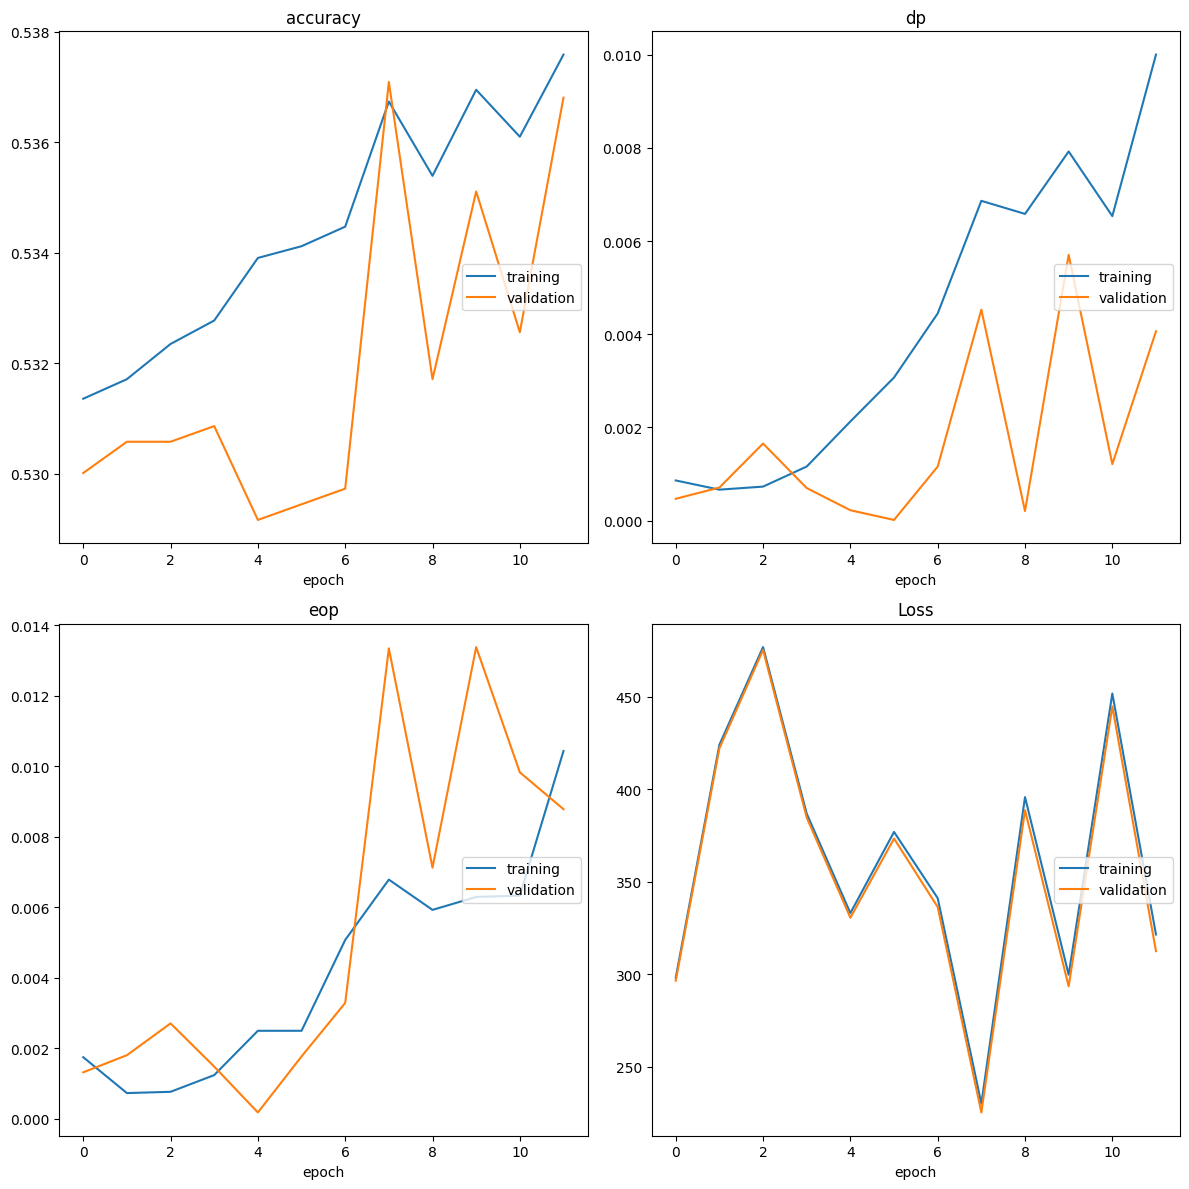

Classifier Training Epoch:   4%|▍         | 21/500 [00:26<08:25,  1.05s/it, acc=0.523, loss=3.15e+3]

accuracy
	training         	 (min:    0.531, max:    0.538, cur:    0.538)
	validation       	 (min:    0.529, max:    0.537, cur:    0.537)
dp
	training         	 (min:    0.001, max:    0.010, cur:    0.010)
	validation       	 (min:    0.000, max:    0.006, cur:    0.004)
eop
	training         	 (min:    0.001, max:    0.010, cur:    0.010)
	validation       	 (min:    0.000, max:    0.013, cur:    0.009)
Loss
	training         	 (min:  230.036, max:  476.764, cur:  321.424)
	validation       	 (min:  225.263, max:  475.226, cur:  312.423)


Classifier Training Epoch:   5%|▍         | 23/500 [00:27<08:25,  1.06s/it, acc=0.504, loss=3.52e+3]E:\Environment\python\python3.7.4\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
E:\Environment\python\python3.7.4\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to s

In [ ]:
train(clf, data.x_train, data.y_train, data.s_train, num_epochs=500, starter_learning_rate=0.0008, eta=1, validation_set=[data.x_val, data.y_val, data.s_val])

In [ ]:
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/prejudice_remover_regularizer
!pip install nnabla-ext-cuda114

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 8716, done.
remote: Counting objects: 100% (1269/1269), done.
remote: Compressing objects: 100% (570/570), done.
remote: Total 8716 (delta 718), reused 1149 (delta 667), pack-reused 7447
Receiving objects: 100% (8716/8716), 295.83 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (4623/4623), done.
Checking out files: 100% (1642/1642), done.
/content/nnabla-examples/responsible_ai/prejudice_remover_regularizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114.8 MB 52 kB/s 
     |████████████████████████████████| 18.8 MB 53.4 MB/s 
     |████████████████████████████████| 132 kB 72.2 MB/s 
     |████████████████████████████████| 1.1 MB 59.4 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 10.1 MB 54.7 MB/s 
     |████████████████████████████████| 140 kB 69.8 MB/s 
  Attempting uninsta

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import nnabla as nn
from nnabla.logger import logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown

from utils import *

In [ ]:
# data preparation
(X_train_new, X_test_new, y_train_new, y_test_new, Z_train_new, Z_test_new) = train_test_split(X_new, y_new, Z_new, test_size=0.3, stratify=y, random_state=7)

scale_orig = StandardScaler()
X_train_new = scale_orig.fit_transform(X_train_new)
X_test_new = scale_orig.fit_transform(X_test_new)

In [ ]:
class dataset(DataSource):
    def __init__(self,features, labels, senstive_attribute, shuffle=False):
        super(dataset, self).__init__(shuffle=shuffle)
        self.x = features
        self.y = labels.reshape(-1, 1)
        self.z = senstive_attribute
        self._size = self.y.size
        self._variables = ('x', 'y', 'z')
        
    def _get_data(self, idx):
        return self.x[idx], self.y[idx], self.z[idx]

trainset = dataset(X_train_new, y_train_new.to_numpy(), Z_train_new.to_numpy(), shuffle=True)
testset = dataset(X_test_new, y_test_new.to_numpy(), Z_test_new.to_numpy())

batchsize = 32
test_batchsize = X_test_new.shape[0]

trainloader = data_iterator(trainset, batch_size=batchsize)
testloader = data_iterator(testset, batch_size=test_batchsize)

In [ ]:
from nnabla.ext_utils import get_extension_context
context = "cudnn" # for cpu set context as 'cpu'
device_id = 0
ctx = get_extension_context(context, device_id=device_id)
nn.set_default_context(ctx)

In [ ]:
n_feature = nn.Variable((batchsize, 9))
n_label = nn.Variable((batchsize, 1))
n_senstive = nn.Variable((batchsize, 1))

test_feature = nn.Variable((test_batchsize, 9))
test_label = nn.Variable((test_batchsize, 1))
test_senstive = nn.Variable((test_batchsize, 1))

In [ ]:
# classifier
def Classifier(features_n, n_hidden=32, p_dropout=0.2,train=True):
    with nn.parameter_scope('classifier'):
        l1 = PF.affine(features_n, n_hidden, name='l1')
        l1 = F.relu(l1)
        if (train):
            l1 = F.dropout(l1,p_dropout)
        l2 = PF.affine(l1, n_hidden, name='l2')
        l2 = F.relu(l2)
        if (train):
            l2 = F.dropout(l2,p_dropout)
        l3 = PF.affine(l2, n_hidden, name='l3')
        l3 = F.relu(l3)
        if (train):
            l3 = F.dropout(l3,p_dropout)
        l4 = PF.affine(l3, 1, name='l4')
    return l4

In [ ]:
clf_new = Classifier(n_feature)
clf_sigm = F.sigmoid(clf_new)
clf_new.persistent = True
clf_sigm.persistent = True
t_clf = Classifier(test_feature,train=False)
loss = F.sum(F.sigmoid_cross_entropy(clf_new, n_label))
loss.persistent = True
learning_rate = 1e-03
clf_solver = S.Adam(learning_rate)
with nn.parameter_scope("classifier"):
    clf_solver.set_parameters(nn.get_parameters())
clf_solver.weight_decay(1e-05)
clf_solver.update()

In [ ]:
max_iter = int(trainloader.size / batchsize)
total_epochs = 10
for epoch in range(total_epochs):
    for i in range(max_iter):
        n_feature.d, n_label.d, _ = trainloader.next()
        clf_solver.zero_grad()
        loss.forward(clear_no_need_grad=True)
        loss.backward(clear_buffer=True)
        clf_solver.update()

In [ ]:
test_feature.d, test_label.d,test_senstive.d = testloader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test_new, preds) * 100

out_a = t_clf_out.d[test_senstive.d == 1]
out_b = t_clf_out.d[test_senstive.d == 0]

clf_cv_score = CVS(out_a,out_b)

In [ ]:
print("Classfier accuracy : ", clf_accuracy,"CV Score :", clf_cv_score) #classifier without PRR

Classfier accuracy :  65.79945799457995 CV Score : 0.2177


In [ ]:
# Prejudice Index implementation
def pr_loss(output_a, output_b, eta):
    N_a = F.constant(output_a.shape[0])
    N_b   = F.constant(output_b.shape[0])
    Dxisi = F.stack(N_b,N_a,axis=0) #aa sample, #cc sample
    # Pr[y|s]
    y_pred_a = F.sum(output_a)
    y_pred_b   = F.sum(output_b)
    P_ys = F.stack(y_pred_b,y_pred_a,axis=0) / Dxisi
    P = F.concatenate(output_a,output_b,axis=0)
    P_y =  F.sum(P) / (output_a.shape[0]+output_b.shape[0])
    P_s1y1 = F.log(P_ys[1]) - F.log(P_y)
    P_s1y0 = F.log(1-P_ys[1]) - F.log(1-P_y)
    P_s0y1 = F.log(P_ys[0]) - F.log(P_y)
    P_s0y0 = F.log(1-P_ys[0]) - F.log(1-P_y)
    
    P_s1y1 = F.reshape(P_s1y1,(P_s1y1.d.size,))
    P_s1y0 = F.reshape(P_s1y0,(P_s1y0.d.size,))
    P_s0y1 = F.reshape(P_s0y1,(P_s0y1.d.size,))
    P_s0y0 = F.reshape(P_s0y0,(P_s0y0.d.size,))
    
    # PI
    PI_s1y1 = output_a * P_s1y1
    PI_s1y0 =(1- output_a) * P_s1y0
    PI_s0y1 = output_b * P_s0y1
    PI_s0y0 = (1- output_b )* P_s0y0
    PI = F.sum(PI_s1y1) + F.sum(PI_s1y0) + F.sum(PI_s0y1) + F.sum(PI_s0y0)
    PI = eta * PI
    return PI

In [ ]:
# training with different eta values
max_iter = int(trainloader.size / batchsize)
acc = []
cvs_score = [] # to plot the CV score
eta_value = [0.0,0.5,1.0,2.0,5.0,10.0,20.0] # Parameter for Prejudice Remover
for eta in eta_value :
    nn.clear_parameters()
    for epoch in range(total_epochs):
        for i in range(max_iter):
            n_feature.d, n_label.d, n_senstive.d = trainloader.next()
            clf_solver.zero_grad()
            clf_sigm.forward(clear_no_need_grad=True)
            output_a = clf_sigm[n_senstive.d == 0]
            output_b = clf_sigm[n_senstive.d == 1]
            PILoss = pr_loss(output_a,output_b,eta)
            t_loss = loss + PILoss
            t_loss.forward(clear_no_need_grad=True)
            t_loss.backward(clear_buffer=True)
            clf_solver.update()
    test_feature.d, test_label.d,test_senstive.d = testloader.next()
    t_clf_out = F.sigmoid(t_clf)
    t_clf_out.forward(clear_buffer=True)
    y_pre_clf = t_clf_out.d.ravel()
    preds = np.where(y_pre_clf > 0.5, 1, 0)
    clf_accuracy = metrics.accuracy_score(y_test_new, preds) * 100
    out_a = t_clf_out.d[test_senstive.d == 0]
    out_b = t_clf_out.d[test_senstive.d == 1]
    cvscore = CVS(out_a,out_b)
    acc.append(clf_accuracy)
    cvs_score.append(cvscore)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated 

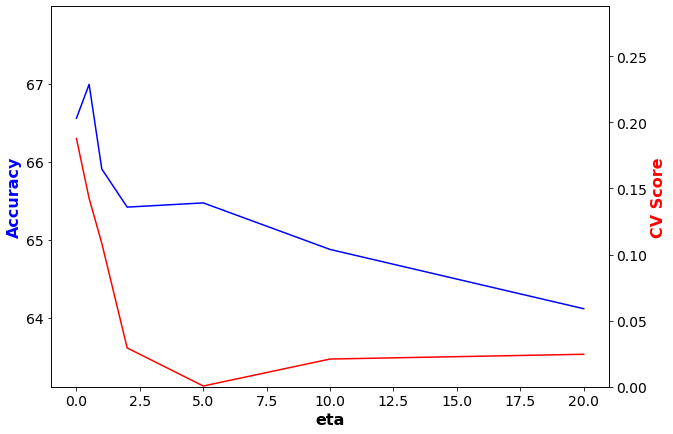

In [ ]:
fairness_plot(eta_value,'eta',acc,"Accuracy",cvs_score,"CV Score") #Graphical Comparison of fairness & performance

In [71]:
# use eta = 15 to train the model
for epoch in range(total_epochs):
  for i in range(max_iter):
    n_feature.d, n_label.d, n_senstive.d = trainloader.next()
    clf_solver.zero_grad()
    clf_sigm.forward(clear_no_need_grad=True)
    output_a = clf_sigm[n_senstive.d == 0]
    output_b = clf_sigm[n_senstive.d == 1]
    PILoss = pr_loss(output_a,output_b,15.0)
    t_loss = loss + PILoss
    t_loss.forward(clear_no_need_grad=True)
    t_loss.backward(clear_buffer=True)
    clf_solver.update()
test_feature.d, test_label.d,test_senstive.d = testloader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test_new, preds)
out_a = t_clf_out.d[test_senstive.d == 0]
out_b = t_clf_out.d[test_senstive.d == 1]
cvscore = CVS(out_a,out_b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [77]:
preds_a = np.where(out_a > 0.5, 1, 0)
preds_b = np.where(out_b > 0.5, 1, 0)
accuracy_AA = metrics.accuracy_score(test_label.d[test_senstive.d==0], preds_a)
accuracy_CC = metrics.accuracy_score(test_label.d[test_senstive.d==1], preds_b)

In [78]:


print('Total accuracy:',clf_accuracy, 'African American accuracy:',accuracy_AA, 'Caucasian accuracy:',accuracy_CC)

Total accuracy: 0.6428184281842818 African American accuracy: 0.6369426751592356 Caucasian accuracy: 0.6514745308310992


# Conditional Non-discrimination classifier

## Determine e

In [ ]:
print(np.sum(clf.predict(X_train_b)==1)/len(X_train_b))
print(np.sum(clf.predict(X_train_w)==1)/len(X_train_w))
D_all=np.sum(clf.predict(X_train_b)==1)/len(X_train_b)-np.sum(clf.predict(X_train_w)==1)/len(X_train_w)
print("D_all:", D_all)

0.5003808073115004
0.2480181200453001
D_all: 0.25236268726620026


In [ ]:
def D_bad_function(x):
    
    # Making male and female subsets of black people:
    B_dataset = X_train_b.groupby(x)
    W_dataset = X_train_w.groupby(x)

    # Total unique values in "sex" column
    n = np.sum(B_dataset[x].nunique())
    
    e = []
    for i in range(n):
        e.append((np.sum(clf.predict(B_dataset.get_group(i))==1)/len(B_dataset.get_group(i))+np.sum(clf.predict(W_dataset.get_group(i))==1)/len(W_dataset.get_group(i)))/n)

    d = []
    for i in range(n):
        d.append((len(B_dataset.get_group(i))/len(X_train_b)-len(W_dataset.get_group(i))/len(X_train_w))*e[i])
    
    D_exp = np.sum(d)
    
    return(D_all-D_exp)

In [ ]:
D_bad_all=[D_bad_function("sex"),D_bad_function("priors_count"),D_bad_function("juv_count"),
           D_bad_function("c_charge_degree"),D_bad_function("score_text")]

([<matplotlib.axis.XTick at 0x7fa700f62e90>,
 [Text(0.0, 0, 'sex'),
  Text(1.0, 0, 'priors_count'),
  Text(2.0, 0, 'juv_count'),
  Text(3.0, 0, 'c_charge_degree'),
  Text(4.0, 0, 'score_text')])

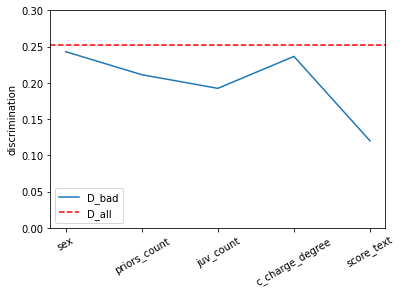

In [ ]:
import matplotlib.pyplot as plt
plt.plot(D_bad_all)
plt.axhline(y = D_all, color = 'r', linestyle = '--')
plt.ylabel("discrimination")
plt.ylim([0,0.3])
plt.legend(["D_bad","D_all"])
plt.xticks([0.0,1.0,2.0,3.0,4.0],["sex","priors_count","juv_count","c_charge_degree","score_text"],rotation=30)

## Algorithm: Local massaging

In [ ]:
#split X_train into different sex, 0:low, 1:medium, 2:high
index_0= (X_train["score_text"]==0)
X_train_0=X_train[index_0]
y_train_0=y_train[index_0]
index_1= (X_train["score_text"]==1)
X_train_1=X_train[index_1]
y_train_1=y_train[index_1]
index_2= (X_train["score_text"]==2)
X_train_2=X_train[index_2]
y_train_2=y_train[index_2]
print(X_train_0.shape,X_train_1.shape,X_train_2.shape)

(2237, 7) (1207, 7) (948, 7)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf_0 = LogisticRegression(random_state=0).fit(X_train_0, y_train_0)
clf_1 = LogisticRegression(random_state=0).fit(X_train_1, y_train_1)
clf_2 = LogisticRegression(random_state=0).fit(X_train_2, y_train_2)

In [ ]:
#get probability for logistic regression
X_train_0["prob_0"],X_train_0["prob_1"]=clf_0.predict_proba(X_train_0)[:,0],clf_0.predict_proba(X_train_0)[:,1]
X_train_1["prob_0"],X_train_1["prob_1"]=clf_1.predict_proba(X_train_1)[:,0],clf_1.predict_proba(X_train_1)[:,1]
X_train_2["prob_0"],X_train_2["prob_1"]=clf_2.predict_proba(X_train_2)[:,0],clf_2.predict_proba(X_train_2)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
index_b= (X_train["race"]==0)
X_train_b=X_train[index_b]
y_train_b=y_train[index_b]
X_train_w=X_train[-index_b]
y_train_w=y_train[-index_b]
print(X_train_b.shape,X_train_w.shape)

(2626, 7) (1766, 7)


In [ ]:
index_b_0= (X_train_b["score_text"]==0)
X_train_b_0=X_train_b[index_b_0]
y_train_b_0=y_train_b[index_b_0]
index_b_1= (X_train_b["score_text"]==1)
X_train_b_1=X_train_b[index_b_1]
y_train_b_1=y_train_b[index_b_1]
index_b_2= (X_train_b["score_text"]==2)
X_train_b_2=X_train_b[index_b_2]
y_train_b_2=y_train_b[index_b_2]

index_w_0= (X_train_w["score_text"]==0)
X_train_w_0=X_train_w[index_w_0]
y_train_w_0=y_train_w[index_w_0]
index_w_1= (X_train_w["score_text"]==1)
X_train_w_1=X_train_w[index_w_1]
y_train_w_1=y_train_w[index_w_1]
index_w_2= (X_train_w["score_text"]==2)
X_train_w_2=X_train_w[index_w_2]
y_train_w_2=y_train_w[index_w_2]

print(X_train_b_0.shape,X_train_b_1.shape,X_train_b_2.shape,X_train_w_0.shape,X_train_w_1.shape,X_train_w_2.shape)

(1084, 7) (808, 7) (734, 7) (1153, 7) (399, 7) (214, 7)


In [ ]:
#e_0
p_plus_e_0=(np.sum(clf_0.predict(X_train_b_0)==1)/len(X_train_b_0)+np.sum(clf_0.predict(X_train_w_0)==1)/len(X_train_w_0))/2
#e_1
p_plus_e_1=(np.sum(clf_1.predict(X_train_b_1)==1)/len(X_train_b_1)+np.sum(clf_1.predict(X_train_w_1)==1)/len(X_train_w_1))/2
#e_2
p_plus_e_2=(np.sum(clf_2.predict(X_train_b_2)==1)/len(X_train_b_2)+np.sum(clf_2.predict(X_train_w_2)==1)/len(X_train_w_2))/2

In [ ]:

delta_b_0=abs(int(len(X_train_b_0)*(np.sum(clf_0.predict(X_train_b_0)==1)/len(X_train_b_0)-p_plus_e_0)))
delta_w_0=abs(int(len(X_train_w_0)*(np.sum(clf_0.predict(X_train_w_0)==1)/len(X_train_w_0)-p_plus_e_0)))

delta_b_1=abs(int(len(X_train_b_1)*(np.sum(clf_1.predict(X_train_b_1)==1)/len(X_train_b_1)-p_plus_e_1)))
delta_w_1=abs(int(len(X_train_w_1)*(np.sum(clf_1.predict(X_train_w_1)==1)/len(X_train_w_1)-p_plus_e_1)))

delta_b_2=abs(int(len(X_train_b_2)*(np.sum(clf_2.predict(X_train_b_2)==1)/len(X_train_b_2)-p_plus_e_2)))
delta_w_2=abs(int(len(X_train_w_2)*(np.sum(clf_2.predict(X_train_w_2)==1)/len(X_train_w_2)-p_plus_e_2)))
print(delta_b_0,delta_w_0,delta_b_1,delta_w_1,delta_b_2,delta_w_2)

21 23 24 11 8 2


In [ ]:
index_p_to_n_0=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values()[:delta_b_0]
index_n_to_p_0=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_0]

index_p_to_n_1=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values()[:delta_b_1]
index_n_to_p_1=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_1]

index_p_to_n_2=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values()[:delta_b_2]
index_n_to_p_2=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_2]

In [ ]:
y_train_new=y_train.copy()
y_train_new[y_train_new.index.isin(index_p_to_n_0.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_0.index)]=1
y_train_new[y_train_new.index.isin(index_p_to_n_1.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_1.index)]=1
y_train_new[y_train_new.index.isin(index_p_to_n_2.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_2.index)]=1

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_new = LogisticRegression(random_state=0).fit(X_train, y_train_new)
clf_new.score(X_test,y_test)

0.6723549488054608

In [ ]:
print("calibration score: ",abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w)))

calibration score:  0.04702340706397501


## Algorithm: Local preferential sampling

In [ ]:
index_p_to_n_0_u=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values()[:int(delta_b_0/2)]
index_p_to_n_0_d=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_0/2)]

index_n_to_p_0_d=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_0/2)]
index_n_to_p_0_u=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values()[:int(delta_w_0/2)]

index_p_to_n_1_u=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values()[:int(delta_b_1/2)]
index_p_to_n_1_d=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_1/2)]

index_n_to_p_1_d=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_1/2)]
index_n_to_p_1_u=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values()[:int(delta_w_1/2)]

index_p_to_n_2_u=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values()[:int(delta_b_2/2)]
index_p_to_n_2_d=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_2/2)]

index_n_to_p_2_d=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_2/2)]
index_n_to_p_2_u=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values()[:int(delta_w_2/2)]

In [ ]:
X_train_new1=X_train.copy()
y_train_new1=y_train.copy()
df_new=pd.concat([X_train_new1,y_train_new1],axis=1)
df_new.drop(index_p_to_n_0_d.index,inplace=True)
df_new.drop(index_n_to_p_0_u.index,inplace=True)
df_new.drop(index_p_to_n_1_d.index,inplace=True)
df_new.drop(index_n_to_p_1_u.index,inplace=True)
df_new.drop(index_p_to_n_2_d.index,inplace=True)
df_new.drop(index_n_to_p_2_u.index,inplace=True)

In [ ]:
df_dup_1=df_new[df_new.index.isin(index_p_to_n_0_u.index)]
df_dup_2=df_new[df_new.index.isin(index_n_to_p_0_d.index)]
df_dup_3=df_new[df_new.index.isin(index_p_to_n_1_u.index)]
df_dup_4=df_new[df_new.index.isin(index_n_to_p_1_d.index)]
df_dup_5=df_new[df_new.index.isin(index_p_to_n_2_u.index)]
df_dup_6=df_new[df_new.index.isin(index_n_to_p_2_d.index)]
df_new_all=df_new.append([df_dup_1,df_dup_2,df_dup_3,df_dup_4,df_dup_4,df_dup_4])

In [ ]:
print(df_new.shape,X_train_new1.shape,df_new_all.shape)

(4350, 8) (4392, 7) (4398, 8)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf_new1 = LogisticRegression(random_state=0).fit(df_new_all.drop("two_year_recid",axis=1), df_new_all["two_year_recid"])
print(clf_new1.score(X_test,y_test))
print("calibration score: ",abs(clf_new1.score(X_test_b,y_test_b)-clf_new1.score(X_test_w,y_test_w)))

0.6689419795221843
calibration score:  0.03390321645899741


# Comparision plots:

## Accuracy plot:

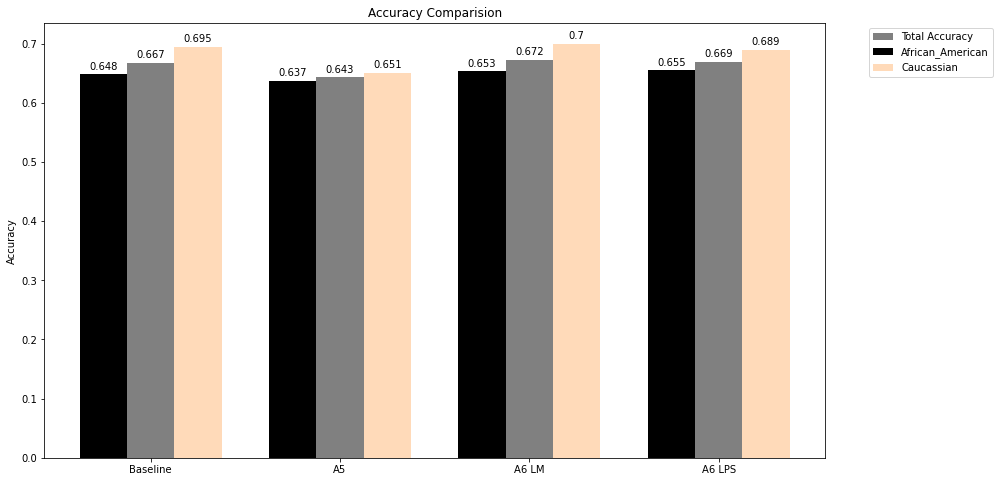

In [79]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Replace 0.555 with true scores:
Accuracy_score             = np.round_([clf.score(X_test,y_test),clf_accuracy, clf_new.score(X_test,y_test),clf_new1.score(X_test,y_test)],3)
Accuracy_African_American  = np.round_([clf.score(X_test_b,y_test_b),accuracy_AA,clf_new.score(X_test_b,y_test_b),clf_new1.score(X_test_b,y_test_b)],3)
Accuracy_Caucassian        = np.round_([clf.score(X_test_w,y_test_w),accuracy_CC,clf_new.score(X_test_w,y_test_w),clf_new1.score(X_test_w,y_test_w)],3)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , Accuracy_score , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, Accuracy_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, Accuracy_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

## Calibration plot:

Text(0.5, 1.0, 'Calibration score Comparision')

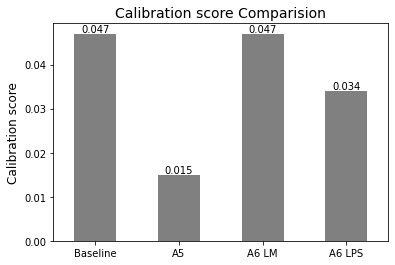

In [80]:
x_labels = ['Baseline','A5', 'A6 LM', 'A6 LPS']

Baseline_cal_score = abs(clf.score(X_test_b,y_test_b)-clf.score(X_test_w,y_test_w))
A5_cal_score = cvscore
A6_LM_cal_score = abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w))
A6_LPS_cal_score = abs(clf_new1.score(X_test_b,y_test_b)-clf_new1.score(X_test_w,y_test_w))      # Enter score here

Calibration_score = np.round([Baseline_cal_score,A5_cal_score,A6_LM_cal_score,A6_LPS_cal_score],3)

score_series = pd.Series(Calibration_score)

plt.figure()
fig = score_series.plot(kind='bar',color="gray")
fig.set_xticklabels(x_labels, rotation=0)
fig.bar_label(fig.containers[0], label_type='edge')
plt.ylabel('Calibration score',fontsize = 12)
plt.title('Calibration score Comparision',fontsize = 14)

## False Positive Rate plot:

In [93]:
#FPR for baseline
from sklearn.metrics import confusion_matrix
y_pred_T = clf.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)

TN_T = CM_T[0][0]
FN_T = CM_T[1][0]
TP_T = CM_T[1][1]
FP_T = CM_T[0][1]

FPR_T = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T)

# African American FPR

y_pred_b = clf.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)

TN_b = CM_b[0][0]
FP_b = CM_b[0][1]

FPR_b = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b)

# Caucasian FPR

y_pred_w = clf.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)

TN_w = CM_w [0][0]
FP_w = CM_w [0][1]

FPR_w = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w)

Total FPR:  0.24733475479744135
African American FPR:  0.340080971659919
Caucasian FPR:  0.14414414414414414


In [94]:
# FPR for A5
#Overall
CM_T = confusion_matrix(y_test_new, preds)
TN_T = CM_T[0][0]
FN_T = CM_T[1][0]
TP_T = CM_T[1][1]
FP_T = CM_T[0][1]

FPR_T_PR = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T)

# African American FPR
CM_b = confusion_matrix(test_label.d[test_senstive.d==0], preds_a)

TN_b = CM_b[0][0]
FP_b = CM_b[0][1]

FPR_b_PR = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b)

# Caucasian FPR

CM_w = confusion_matrix(test_label.d[test_senstive.d==1],preds_b)

TN_w = CM_w [0][0]
FP_w = CM_w [0][1]

FPR_w_PR = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w)

Total FPR:  0.24733475479744135
African American FPR:  0.340080971659919
Caucasian FPR:  0.14414414414414414


In [95]:
# FPR for A6 LM

# Overall FPR
y_pred_T = clf_new.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)
TN_T = CM_T[0][0]
FP_T = CM_T[0][1]
FPR_T_LM = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T_LM)


# African American FPR
y_pred_b = clf_new.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)
TN_b = CM_b[0][0]
FP_b = CM_b[0][1]
FPR_b_LM = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b_LM)


# Caucasian FPR
y_pred_w = clf_new.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)
TN_w = CM_w [0][0]
FP_w = CM_w [0][1]
FPR_w_LM = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w_LM)

Total FPR:  0.23880597014925373
African American FPR:  0.31983805668016196
Caucasian FPR:  0.14864864864864866


In [96]:
# FPR for A6 LPS
from sklearn.metrics import confusion_matrix
# Overall FPR
y_pred_T = clf_new1.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)
TN_T = CM_T[0][0]
FP_T = CM_T[0][1]
FPR_T_LPS = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T_LPS)

# African American FPR
y_pred_b = clf_new1.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)
TN_b = CM_b[0][0]
FP_b = CM_b[0][1]
FPR_b_LPS = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b_LPS)

# Caucasian FPR
y_pred_w = clf_new1.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)
TN_w = CM_w [0][0]
FP_w = CM_w [0][1]
FPR_w_LPS = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w_LPS)

Total FPR:  0.24520255863539445
African American FPR:  0.3360323886639676
Caucasian FPR:  0.14414414414414414


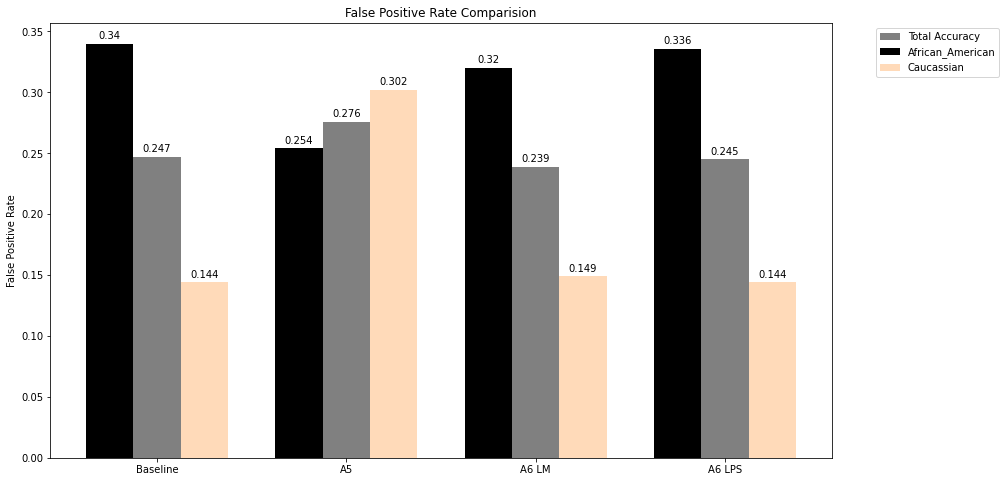

In [97]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Insert scores here:
FPR_score             = np.round_([FPR_T,FPR_T_PR, FPR_T_LM, FPR_T_LPS],3)
FPR_African_American  = np.round_([FPR_b,FPR_b_PR, FPR_b_LM, FPR_b_LPS],3)
FPR_Caucassian        = np.round_([FPR_w,FPR_w_PR, FPR_w_LM, FPR_w_LPS],3)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , FPR_score  , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, FPR_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, FPR_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('False Positive Rate')
ax.set_title('False Positive Rate Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()